## Clickbait Classifier

#### Importing and setting up clickbait dataset

In [1]:
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# load clickbait dataset
clickbait_data = pd.read_csv('clickbait_data.csv')

# function to clean text
def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    text = re.sub(r'\d+', '', text)     # remove numbers
    text = text.lower()                 # convert to lowercase
    return text

# apply text cleaning
clickbait_data['cleaned_headline'] = clickbait_data['headline'].apply(clean_text)

# split dataset into features (X) and labels (y)
X = clickbait_data['cleaned_headline']
y = clickbait_data['clickbait']

# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# vectorize text using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

#### Testing Logistic Regression, Random Forest, and SVM

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# train multiple classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(C=10, solver='saga', penalty='l2', max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(max_depth=None, min_samples_split=2, min_samples_leaf=1, n_estimators=500, random_state=42),
    'Support Vector Machine (SVM)': SVC(C=10, class_weight=None, gamma='scale', kernel='rbf', random_state=42)
}

# Store results for comparison
results = {}

# Loop over classifiers to train and evaluate
for clf_name, clf in classifiers.items():
    
    # Fit classifier
    clf.fit(X_train_tfidf, y_train)
    
    # Make predictions
    y_pred = clf.predict(X_test_tfidf)
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    # Store results
    results[clf_name] = {'accuracy': accuracy, 'report': report}

# Display comparison results
for clf_name, result in results.items():
    print(f"\n{clf_name} Results:")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print(f"Classification Report:\n{result['report']}")


Logistic Regression Results:
Accuracy: 0.9489
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      3200
           1       0.96      0.94      0.95      3200

    accuracy                           0.95      6400
   macro avg       0.95      0.95      0.95      6400
weighted avg       0.95      0.95      0.95      6400


Random Forest Results:
Accuracy: 0.9255
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.92      3200
           1       0.91      0.95      0.93      3200

    accuracy                           0.93      6400
   macro avg       0.93      0.93      0.93      6400
weighted avg       0.93      0.93      0.93      6400


Support Vector Machine (SVM) Results:
Accuracy: 0.9516
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      3200
           1       0.95 

#### Model creation + Grid search

In [3]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Test different regularization strengths
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],  # Gamma values for RBF kernel
    'kernel': ['rbf'],  # Use RBF since it was the best in your earlier model
    'class_weight': [None, 'balanced']  # Include balancing options for imbalanced data
}

# Initialize the model
svc = SVC(random_state=42)

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy as the evaluation metric (change as needed)
    cv=2,  # 5-fold cross-validation
    verbose=2,  # Verbose output for progress monitoring
    n_jobs=-1  # Use all available processors for speed
)

# Perform the grid search
grid_search.fit(X_train_tfidf, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Output the results
print("Best parameters:", best_params)
print("Best cross-validation accuracy:", grid_search.best_score_)

Fitting 2 folds for each of 40 candidates, totalling 80 fits
[CV] END ..C=0.1, class_weight=None, gamma=scale, kernel=rbf; total time=  19.2s
[CV] END ..C=0.1, class_weight=None, gamma=scale, kernel=rbf; total time=  19.4s
[CV] END ....C=0.1, class_weight=None, gamma=0.1, kernel=rbf; total time=  20.0s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  20.1s
[CV] END ...C=0.1, class_weight=None, gamma=0.01, kernel=rbf; total time=  20.3s
[CV] END ....C=0.1, class_weight=None, gamma=0.1, kernel=rbf; total time=  20.3s
[CV] END ...C=0.1, class_weight=None, gamma=auto, kernel=rbf; total time=  20.7s
[CV] END ...C=0.1, class_weight=None, gamma=auto, kernel=rbf; total time=  20.8s
[CV] END ......C=0.1, class_weight=None, gamma=1, kernel=rbf; total time=  18.6s
[CV] END ......C=0.1, class_weight=None, gamma=1, kernel=rbf; total time=  18.4s
[CV] END C=0.1, class_weight=balanced, gamma=scale, kernel=rbf; total time=  18.2s
[CV] END C=0.1, class_weight=balanced, gamma=a

In [3]:
# create our model using the best option from above
model = SVC(C=10, class_weight=None, gamma='scale', kernel='rbf', random_state=42)
model.fit(X_train_tfidf, y_train)

SVC(C=10, random_state=42)

#### Importing and setting up NYT in-person headlines

In [14]:
# load the NYT headlines from 1998.csv to 2004.csv
years = range(1998, 2005)
nyt_data = []

for year in years:
    # read each year's file
    file_path = f"{year}.csv"
    data = pd.read_csv(file_path)
    
    # extract the 'Headline' column and add year information
    data['Year'] = year
    nyt_data.append(data[['Headline', 'Year', 'Publication Date']])

# concatenate all the data into a single DataFrame
nyt_df = pd.concat(nyt_data, ignore_index=True)

/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2556960829.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2556960829.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2556960829.py:8: DtypeWarning: Columns (0,7,25,26,27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2556960829.py:8: DtypeWarning: Columns (7,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2556960829.py:8: DtypeWarning: Columns (7) have mixed types. S

#### Applying clickbait model to cleaned headlines

In [16]:
nyt_df = nyt_df.dropna()

# apply text cleaning
nyt_df['Headline'] = nyt_df['Headline'].apply(clean_text)

nyt_tfidf = vectorizer.fit_transform(nyt_df['Headline'])

# use the trained SVM model to predict whether each headline is clickbait
y_pred_nyt = model.predict(nyt_tfidf)

# add predictions to the DataFrame
nyt_df['Predicted Clickbait'] = y_pred_nyt

print(nyt_df.head())

/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/1624243490.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_df['Headline'] = nyt_df['Headline'].apply(clean_text)


                                            Headline  Year Publication Date  \
0                    paid notice deaths kraft norman  1998       1998-02-23   
1                               quotation of the day  1998       1998-02-23   
2  library of congress plans to post black histor...  1998       1998-02-23   
3  lincolns absolutism could be relative required...  1998       1998-02-23   
4  white house denies using investigators to go a...  1998       1998-02-23   

   Month  Predicted Clickbait  
0      2                    0  
1      2                    0  
2      2                    0  
3      2                    0  
4      2                    1  


/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/1624243490.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_df['Predicted Clickbait'] = y_pred_nyt


#### Visualizing clickbait by year

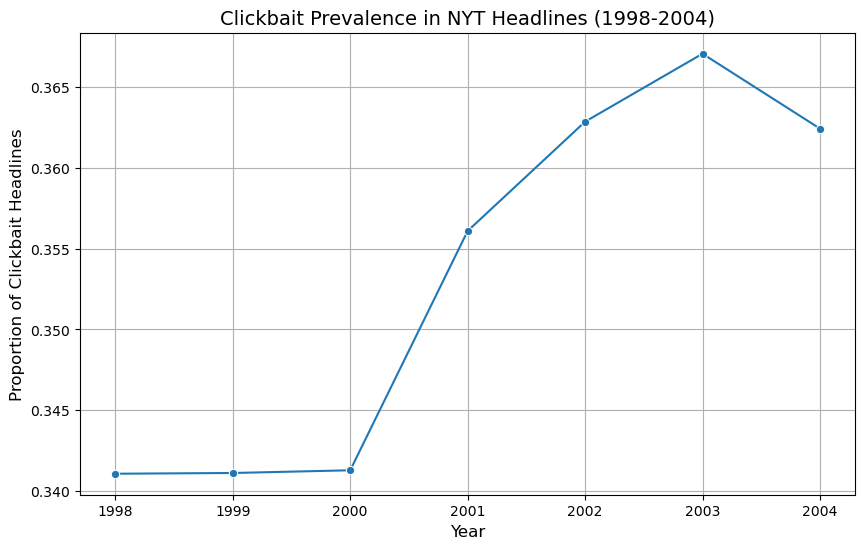

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# analyze the proportion of clickbait headlines each year
clickbait_by_year = nyt_df.groupby('Year')['Predicted Clickbait'].mean()

# visualize the trend of clickbait headlines over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=clickbait_by_year.index, y=clickbait_by_year.values, marker='o')

# add titles and labels
plt.title('Clickbait Prevalence in NYT Headlines (1998-2004)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Proportion of Clickbait Headlines', fontsize=12)
plt.xticks(ticks=years)
plt.grid(True)
plt.savefig('clickbait_by_year.png')

plt.show()

/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2378421288.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_df['Publication Date'] = pd.to_datetime(nyt_df['Publication Date'])
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2378421288.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nyt_df['Year'] = nyt_df['Publication Date'].dt.year
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/2378421288.py:10: SettingWithCopyWarning: 
A value is trying to be 

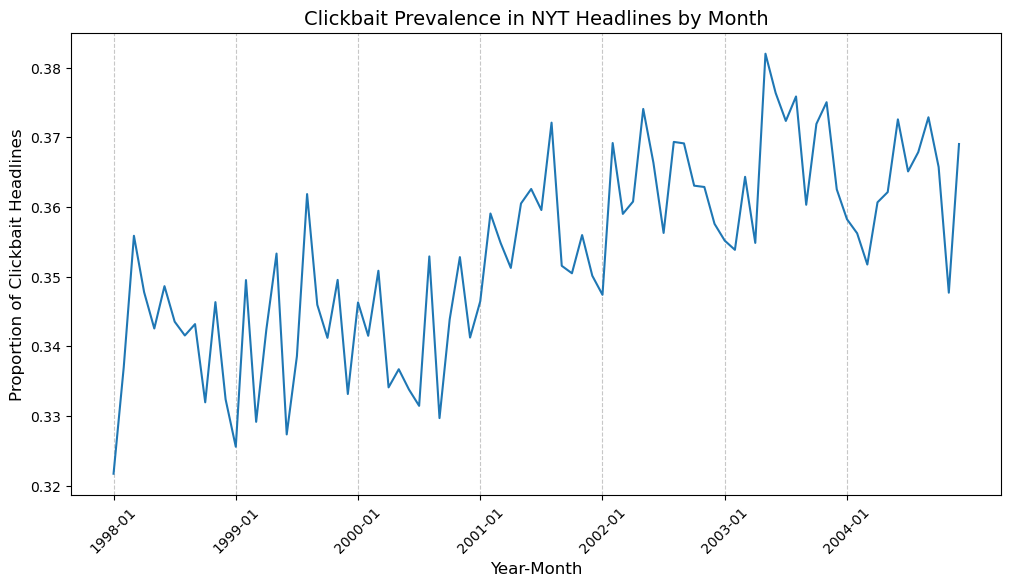

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure the 'Publication Date' column is a datetime object
nyt_df['Publication Date'] = pd.to_datetime(nyt_df['Publication Date'])

# Extract year and month from 'Publication Date'
nyt_df['Year'] = nyt_df['Publication Date'].dt.year
nyt_df['Month'] = nyt_df['Publication Date'].dt.month

# Group by year and month, then calculate the mean predicted clickbait proportion
clickbait_by_month = (
    nyt_df.groupby(['Year', 'Month'])['Predicted Clickbait']
    .mean()
    .reset_index()
)

# Create a new column for easier labeling (e.g., "1998-01", "1998-02", ...)
clickbait_by_month['Year-Month'] = (
    clickbait_by_month['Year'].astype(str) + '-' + clickbait_by_month['Month'].astype(str).str.zfill(2)
)

# Sort by 'Year-Month' for proper ordering
clickbait_by_month = clickbait_by_month.sort_values('Year-Month')

# Visualize the trend of clickbait headlines by month
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year-Month', y='Predicted Clickbait', data=clickbait_by_month)

# Add titles and labels
plt.title('Clickbait Prevalence in NYT Headlines by Month', fontsize=14)
plt.xlabel('Year-Month', fontsize=12)
plt.ylabel('Proportion of Clickbait Headlines', fontsize=12)

# Rotate x-axis labels for better visibility
january_labels = clickbait_by_month[clickbait_by_month['Month'] == 1]['Year-Month']

plt.xticks(ticks=january_labels.index, labels=january_labels, rotation=45, fontsize=10)
plt.grid(axis='x', which='major', linestyle='--', alpha=0.7)
plt.gca().set_xticks(january_labels.index, minor=False)
plt.gca().set_xticks([], minor=True)

# Save the plot
plt.savefig('clickbait_by_month.png')

# Show the plot
plt.show()

#### Creating the same model except it predicts probability instead of a binary classification

In [7]:
model = SVC(probability=True, C=10, class_weight=None, gamma='scale', kernel='rbf', random_state=42)
model.fit(X_train_tfidf, y_train)

SVC(C=10, probability=True, random_state=42)

#### Applying model to NYT in-person headlines

In [8]:
nyt_probabilities = model.predict_proba(nyt_tfidf)

# add the probabilities to the DataFrame
nyt_df['Clickbait Probability'] = nyt_probabilities[:, 1]  # Probability for class "clickbait"

#### Visualizing clickbait probability by year

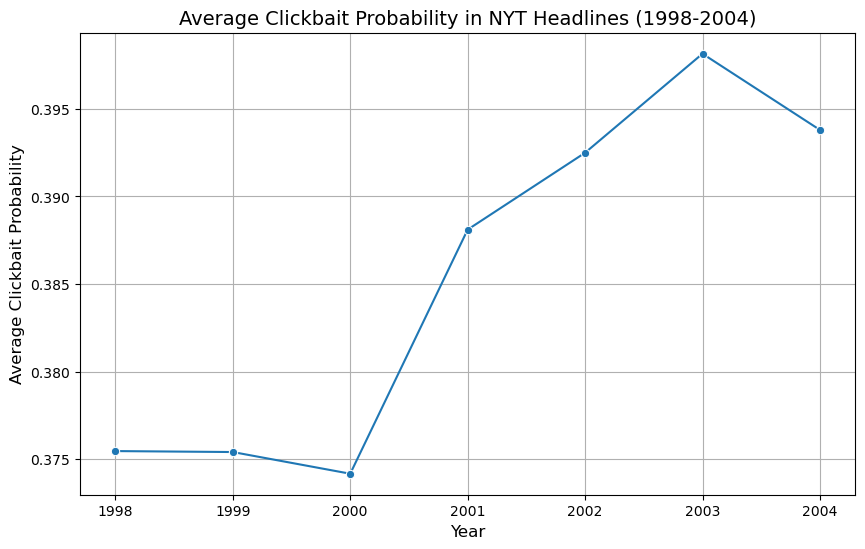

In [9]:
# calculate the average clickbait probability for each year
avg_clickbait_prob_by_year = nyt_df.groupby('Year')['Clickbait Probability'].mean()

# plot the trend over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=avg_clickbait_prob_by_year.index, y=avg_clickbait_prob_by_year.values, marker='o')

# add titles and labels
plt.title('Average Clickbait Probability in NYT Headlines (1998-2004)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Clickbait Probability', fontsize=12)
plt.xticks(ticks=years)
plt.grid(True)
plt.savefig("clickbait_prob.png")

plt.show()

#### Applying model to online headlines

In [10]:
# initialize an empty list to store online headline data
online_headline_data = []

# iterate over the years with Online Headline column
for year in range(2001, 2005):
    # read the file
    file_path = f"{year}.csv"
    data = pd.read_csv(file_path)
    
    # extract the Online Headline column and year
    if 'Online Headline' in data.columns:
        online_headlines = data[['Online Headline']].copy()
        online_headlines['Year'] = year
        online_headlines.rename(columns={'Online Headline': 'Headline'}, inplace=True)  # Standardize column name
        online_headline_data.append(online_headlines)

# combine all online headlines into a single DataFrame
online_df = pd.concat(online_headline_data, ignore_index=True)

online_df = online_df.dropna()

# apply text cleaning
online_df['Headline'] = online_df['Headline'].apply(clean_text)

# preprocess the online headlines using the same vectorizer
online_tfidf = vectorizer.transform(online_df['Headline'])

# predict probabilities for the online headlines
online_probabilities = model.predict_proba(online_tfidf)

# add probabilities to the DataFrame
online_df['Clickbait Probability'] = online_probabilities[:, 1]

/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/1210786530.py:8: DtypeWarning: Columns (7,32) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/1210786530.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)
/var/folders/qp/4b80075172jdb6pz_89jkhq00000gn/T/ipykernel_26568/1210786530.py:8: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [11]:
# calculate average clickbait probability for in-person headlines by year
headline_probs_by_year = nyt_df.groupby('Year')['Clickbait Probability'].mean()

# calculate average clickbait probability for online headlines by year
online_probs_by_year = online_df.groupby('Year')['Clickbait Probability'].mean()

#### Visualizing clickbait probability for in-person and online headlines

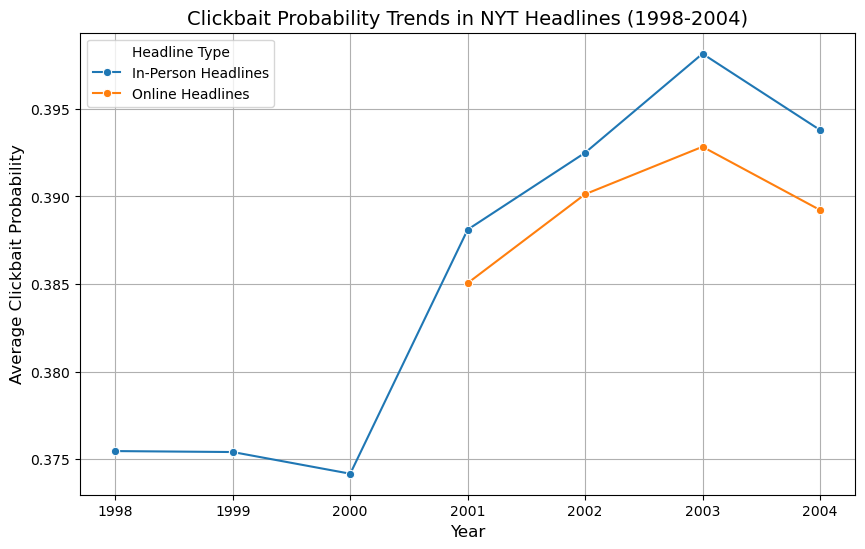

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# create a DataFrame for visualization
combined_probs = pd.DataFrame({
    'In-Person Headlines': headline_probs_by_year,
    'Online Headlines': online_probs_by_year
}).reset_index()

# melt the DataFrame for easier plotting with Seaborn
combined_probs_melted = combined_probs.melt(id_vars='Year', 
                                            var_name='Headline Type', 
                                            value_name='Average Clickbait Probability')

# plot the trends
plt.figure(figsize=(10, 6))
sns.lineplot(data=combined_probs_melted, x='Year', y='Average Clickbait Probability', 
             hue='Headline Type', marker='o')

# add titles and labels
plt.title('Clickbait Probability Trends in NYT Headlines (1998-2004)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Clickbait Probability', fontsize=12)
plt.xticks(ticks=range(1998, 2005))
plt.grid(True)
plt.legend(title='Headline Type')
plt.savefig("clickbait_prob_online.png")

plt.show()